In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

!pip -q install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
pd.set_option('display.max_columns', None)


In [ ]:
# Load data
FILE_PATH = "/content/loan_approval_dataset.csv"

df = pd.read_csv(FILE_PATH)
print("Shape:", df.shape)
df.head()


Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
# Quick EDA and target check
print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum())

# Inspect target distribution
target_col = " loan_status"
print("\nTarget value counts:")
print(df[target_col].value_counts(dropna=False))
print("\nTarget rate (percentage):")
print(df[target_col].value_counts(normalize=True).mul(100).round(2))

loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object

Missing values per column:
loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

Target value counts:
 loan_status
Approved    2656
Rejected    1613
Name:

In [ ]:
# Clean target to binary {0,1}
# Map to binary: Approved=1, Rejected=0
df[target_col] = df[target_col].str.strip()
df[target_col] = df[target_col].map({"Approved": 1, "Rejected": 0})

# Drop rows with unknown target
df = df.dropna(subset=[target_col])

print("After target cleaning:")
print(df[target_col].value_counts())


After target cleaning:
 loan_status
1    2656
0    1613
Name: count, dtype: int64


In [ ]:
# Identify features and their types
id_col = "loan_id"  # not predictive
X = df.drop(columns=[target_col, id_col], errors="ignore")
y = df[target_col].astype(int)

# Identify categorical and numeric features based on dtype and known columns
# From your schema: education, self_employed are categorical; rest are numeric
categorical_cols = []
numeric_cols = []

for c in X.columns:
    if X[c].dtype == "object":
        categorical_cols.append(c)
    else:
        numeric_cols.append(c)

# Ensure known categoricals are included (in case parsed as object)
for c in ["education", "self_employed"]:
    if c in X.columns and c not in categorical_cols:
        categorical_cols.append(c)
        if c in numeric_cols:
            numeric_cols.remove(c)

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)


Categorical: [' education', ' self_employed']
Numeric: [' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']


In [ ]:
# Train/validation split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True).round(3))
print("Test target distribution:\n", y_test.value_counts(normalize=True).round(3))


Train size: (3415, 11)  Test size: (854, 11)
Train target distribution:
  loan_status
1    0.622
0    0.378
Name: proportion, dtype: float64
Test target distribution:
  loan_status
1    0.622
0    0.378
Name: proportion, dtype: float64


In [ ]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop",
    sparse_threshold=1.0
)

In [ ]:
# Baseline model - Logistic Regression with class_weight balanced
log_reg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    solver="liblinear",
    n_jobs=None
)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", log_reg)
])

pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression (class_weight=balanced) Results:")
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba_lr))


Logistic Regression (class_weight=balanced) Results:
              precision    recall  f1-score   support

           0     0.8772    0.9288    0.9023       323
           1     0.9551    0.9209    0.9377       531

    accuracy                         0.9239       854
   macro avg     0.9161    0.9248    0.9200       854
weighted avg     0.9256    0.9239    0.9243       854

ROC-AUC: 0.973156553730621
PR-AUC (Average Precision): 0.9851668920449956


In [ ]:
# Baseline model - Decision Tree with class_weight
dt = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5
)

pipe_dt = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", dt)
])

pipe_dt.fit(X_train, y_train)

y_pred_dt = pipe_dt.predict(X_test)
y_proba_dt = pipe_dt.predict_proba(X_test)[:, 1]

print("Decision Tree (class_weight=balanced) Results:")
print(classification_report(y_test, y_pred_dt, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba_dt))


Decision Tree (class_weight=balanced) Results:
              precision    recall  f1-score   support

           0     0.9723    0.9783    0.9753       323
           1     0.9868    0.9831    0.9849       531

    accuracy                         0.9813       854
   macro avg     0.9795    0.9807    0.9801       854
weighted avg     0.9813    0.9813    0.9813       854

ROC-AUC: 0.9892427979220233
PR-AUC (Average Precision): 0.9875624944065288


In [ ]:
# Handle class imbalance with SMOTE + Logistic Regression
# SMOTE must be applied after preprocessing numeric+encoded features.
# We'll use an imblearn Pipeline: preprocess -> SMOTE -> model

smote = SMOTE(random_state=42, k_neighbors=5)

log_reg_smote = LogisticRegression(
    max_iter=500,
    class_weight=None,  # SMOTE balances the classes, class_weight often not needed
    solver="liblinear"
)

imb_pipe_lr = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", smote),
    ("clf", log_reg_smote)
])

imb_pipe_lr.fit(X_train, y_train)

y_pred_lr_sm = imb_pipe_lr.predict(X_test)
y_proba_lr_sm = imb_pipe_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression + SMOTE Results:")
print(classification_report(y_test, y_pred_lr_sm, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr_sm))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba_lr_sm))


Logistic Regression + SMOTE Results:
              precision    recall  f1-score   support

           0     0.8761    0.9195    0.8973       323
           1     0.9495    0.9209    0.9350       531

    accuracy                         0.9204       854
   macro avg     0.9128    0.9202    0.9161       854
weighted avg     0.9218    0.9204    0.9207       854

ROC-AUC: 0.973057435879496
PR-AUC (Average Precision): 0.9850657922813818


In [ ]:
# Handle class imbalance with SMOTE + Logistic Regression
# SMOTE must be applied after preprocessing numeric+encoded features.
# We'll use an imblearn Pipeline: preprocess -> SMOTE -> model

smote = SMOTE(random_state=42, k_neighbors=5)

log_reg_smote = LogisticRegression(
    max_iter=500,
    class_weight=None,  # SMOTE balances the classes, class_weight often not needed
    solver="liblinear"
)

imb_pipe_lr = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", smote),
    ("clf", log_reg_smote)
])

imb_pipe_lr.fit(X_train, y_train)

y_pred_lr_sm = imb_pipe_lr.predict(X_test)
y_proba_lr_sm = imb_pipe_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression + SMOTE Results:")
print(classification_report(y_test, y_pred_lr_sm, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr_sm))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba_lr_sm))


Logistic Regression + SMOTE Results:
              precision    recall  f1-score   support

           0     0.8761    0.9195    0.8973       323
           1     0.9495    0.9209    0.9350       531

    accuracy                         0.9204       854
   macro avg     0.9128    0.9202    0.9161       854
weighted avg     0.9218    0.9204    0.9207       854

ROC-AUC: 0.973057435879496
PR-AUC (Average Precision): 0.9850657922813818


In [ ]:
# SMOTE + Decision Tree
dt_smote = DecisionTreeClassifier(
    random_state=42,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5
)

imb_pipe_dt = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", smote),
    ("clf", dt_smote)
])

imb_pipe_dt.fit(X_train, y_train)

y_pred_dt_sm = imb_pipe_dt.predict(X_test)
y_proba_dt_sm = imb_pipe_dt.predict_proba(X_test)[:, 1]

print("Decision Tree + SMOTE Results:")
print(classification_report(y_test, y_pred_dt_sm, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt_sm))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba_dt_sm))


Decision Tree + SMOTE Results:
              precision    recall  f1-score   support

           0     0.9751    0.9690    0.9720       323
           1     0.9812    0.9849    0.9831       531

    accuracy                         0.9789       854
   macro avg     0.9782    0.9770    0.9776       854
weighted avg     0.9789    0.9789    0.9789       854

ROC-AUC: 0.9863829563939759
PR-AUC (Average Precision): 0.9854593076377169


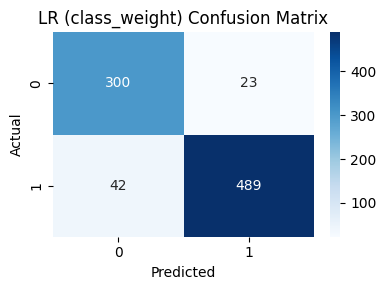

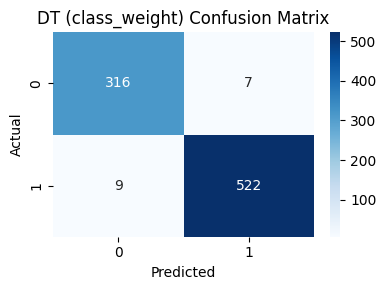

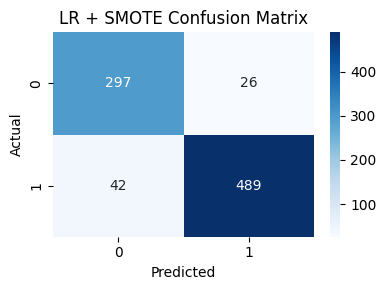

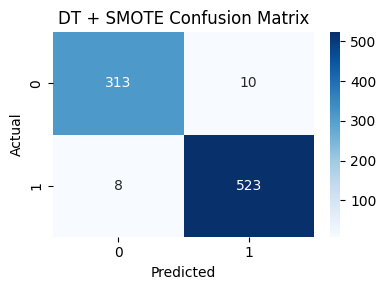

In [ ]:
# Confusion matrices for best models
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plot_confusion(y_test, y_pred_lr, "LR (class_weight) Confusion Matrix")
plot_confusion(y_test, y_pred_dt, "DT (class_weight) Confusion Matrix")
plot_confusion(y_test, y_pred_lr_sm, "LR + SMOTE Confusion Matrix")
plot_confusion(y_test, y_pred_dt_sm, "DT + SMOTE Confusion Matrix")


<Figure size 600x500 with 0 Axes>

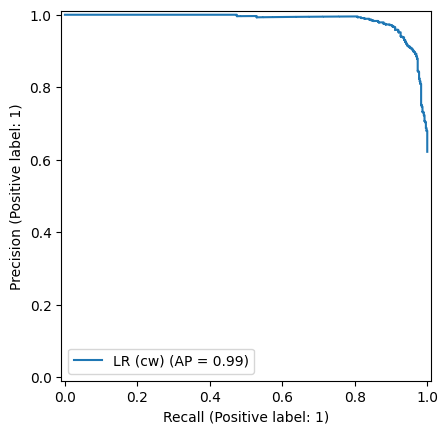

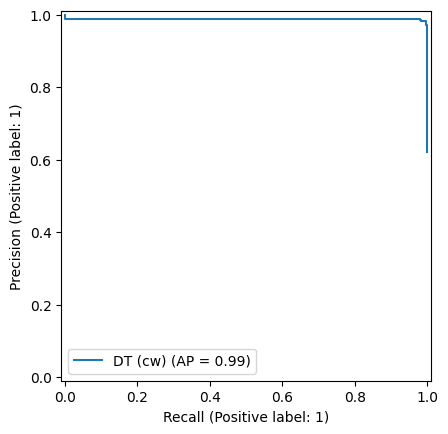

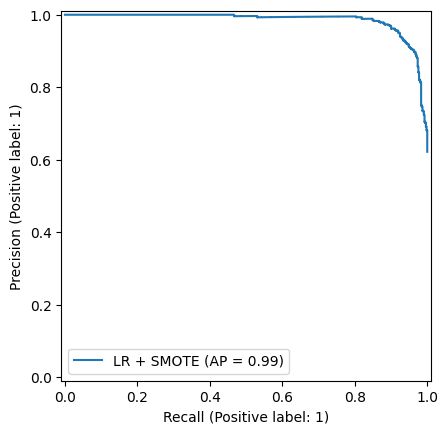

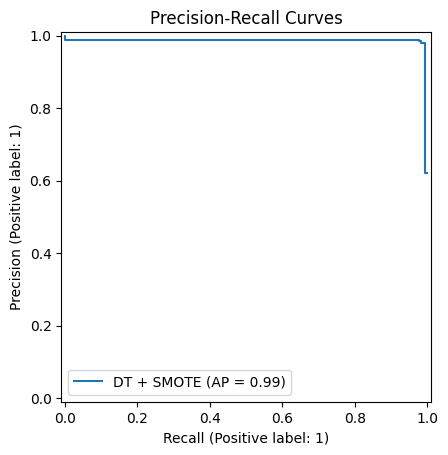

<Figure size 600x500 with 0 Axes>

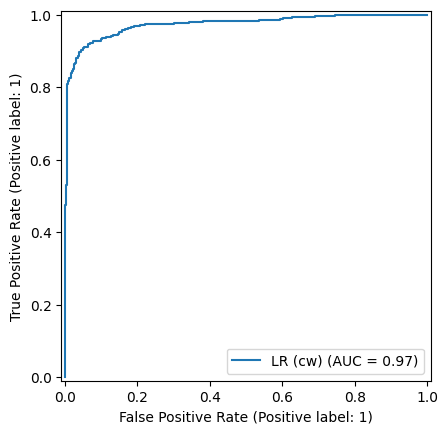

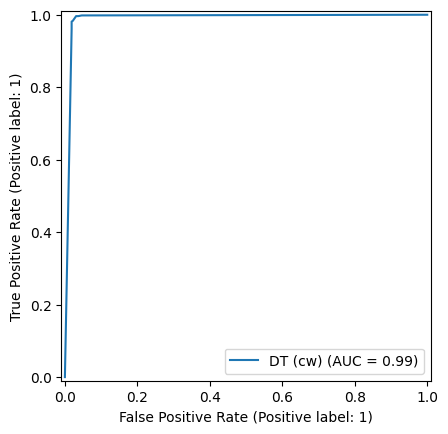

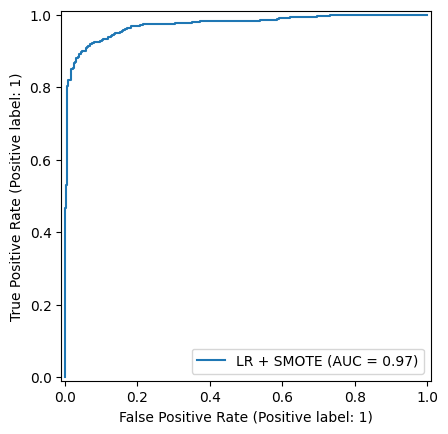

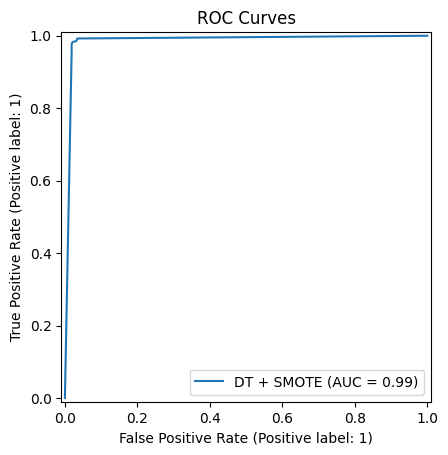

In [ ]:
# Precision-Recall and ROC curves (compare models)
plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr, name="LR (cw)")
PrecisionRecallDisplay.from_predictions(y_test, y_proba_dt, name="DT (cw)")
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr_sm, name="LR + SMOTE")
PrecisionRecallDisplay.from_predictions(y_test, y_proba_dt_sm, name="DT + SMOTE")
plt.title("Precision-Recall Curves")
plt.show()

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="LR (cw)")
RocCurveDisplay.from_predictions(y_test, y_proba_dt, name="DT (cw)")
RocCurveDisplay.from_predictions(y_test, y_proba_lr_sm, name="LR + SMOTE")
RocCurveDisplay.from_predictions(y_test, y_proba_dt_sm, name="DT + SMOTE")
plt.title("ROC Curves")
plt.show()


In [ ]:
# Cross-validation (stratified) on training set for the best two candidates
# Choose models you want to compare in CV (e.g., LR + SMOTE and DT + SMOTE)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_scores(pipe, X, y, name):
    scoring = {
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc"
    }
    scores = cross_validate(pipe, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"\nCV scores for {name}:")
    for k, v in scores.items():
        if k.startswith("test_"):
            print(f"{k.replace('test_', '').upper()}: {np.mean(v):.4f} ± {np.std(v):.4f}")

cv_scores(imb_pipe_lr, X_train, y_train, "LR + SMOTE")
cv_scores(imb_pipe_dt, X_train, y_train, "DT + SMOTE")



CV scores for LR + SMOTE:
PRECISION: 0.9513 ± 0.0100
RECALL: 0.9087 ± 0.0145
F1: 0.9294 ± 0.0103
ROC_AUC: 0.9661 ± 0.0081

CV scores for DT + SMOTE:
PRECISION: 0.9835 ± 0.0032
RECALL: 0.9831 ± 0.0097
F1: 0.9833 ± 0.0044
ROC_AUC: 0.9863 ± 0.0054


Best F1 threshold ~ 0.523, F1=0.9376, Precision=0.9569, Recall=0.9190

Classification report at tuned threshold:
              precision    recall  f1-score   support

           0     0.8750    0.9319    0.9025       323
           1     0.9569    0.9190    0.9376       531

    accuracy                         0.9239       854
   macro avg     0.9159    0.9255    0.9201       854
weighted avg     0.9259    0.9239    0.9243       854



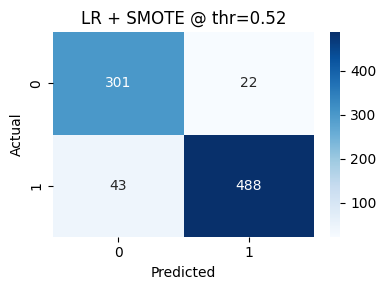

In [ ]:
# Threshold tuning for the best performing model (example: LR + SMOTE)
proba = y_proba_lr_sm  # probabilities from LR + SMOTE on test set

prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5

print(f"Best F1 threshold ~ {best_thr:.3f}, F1={f1[best_idx]:.4f}, Precision={prec[best_idx]:.4f}, Recall={rec[best_idx]:.4f}")

# Re-evaluate at best threshold
y_pred_best = (proba >= best_thr).astype(int)
print("\nClassification report at tuned threshold:")
print(classification_report(y_test, y_pred_best, digits=4))
plot_confusion(y_test, y_pred_best, f"LR + SMOTE @ thr={best_thr:.2f}")


In [ ]:
# Feature importance / coefficients
# For linear model (LR), we can inspect coefficients of the final trained model.
# Need to extract feature names from the ColumnTransformer + OneHotEncoder.

def get_feature_names(preprocess, numeric_cols, categorical_cols):
    feat_names = []
    # numeric names
    feat_names.extend(numeric_cols)
    # categorical names from OHE
    ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    feat_names.extend(list(cat_feature_names))
    return feat_names

# Fit a standalone preprocessing on full training to build names consistently
preprocess_fit = preprocess.fit(X_train)

feature_names = get_feature_names(preprocess_fit, numeric_cols, categorical_cols)

# For LR + SMOTE pipeline, access the fitted classifier
lr_clf = imb_pipe_lr.named_steps["clf"]
if hasattr(lr_clf, "coef_"):
    coef = lr_clf.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)
    display(coef_df.head(15))
    display(coef_df.tail(15))
else:
    print("Model does not expose coefficients.")


,feature,coef
4,cibil_score,4.116164
2,loan_amount,1.326255
7,luxury_assets_value,0.172766
8,bank_asset_value,0.145458
6,commercial_assets_value,0.071833
5,residential_assets_value,0.066513
0,no_of_dependents,-0.063883
3,loan_term,-0.815829
1,income_annum,-1.620275
9,education_ Graduate,-2.762959


,feature,coef
4,cibil_score,4.116164
2,loan_amount,1.326255
7,luxury_assets_value,0.172766
8,bank_asset_value,0.145458
6,commercial_assets_value,0.071833
5,residential_assets_value,0.066513
0,no_of_dependents,-0.063883
3,loan_term,-0.815829
1,income_annum,-1.620275
9,education_ Graduate,-2.762959


In [ ]:
# Save the best pipeline
# Choose the best pipeline (based on validation results). Example: LR + SMOTE
BEST_MODEL_PATH = "loan_approval_best_pipeline.joblib"
joblib.dump(imb_pipe_lr, BEST_MODEL_PATH)
print("Saved best pipeline to:", BEST_MODEL_PATH)


Saved best pipeline to: loan_approval_best_pipeline.joblib


In [ ]:
# Load and predict on new data (inference demo)
# Example usage for production-like inference:

def load_model(path=BEST_MODEL_PATH):
    return joblib.load(path)

def predict_loan_approval(model, df_new):
    # df_new should have the same feature columns as training (excluding target/id)
    proba = model.predict_proba(df_new)[:, 1]
    preds = model.predict(df_new)
    return preds, proba

# demo on a few rows from test
model = load_model()
demo_preds, demo_proba = predict_loan_approval(model, X_test.head(5))
pd.DataFrame({
    "pred": demo_preds,
    "proba_Approved": demo_proba
}, index=X_test.head(5).index)


,pred,proba_Approved
2856,1,0.985932
3176,0,0.011440
477,1,0.521465
4023,1,0.972218
134,1,0.969733


from matplotlib import pyplot as plt
_df_50['pred'].plot(kind='hist', bins=20, title='pred')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_51['proba_Approved'].plot(kind='hist', bins=20, title='proba_Approved')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_52.plot(kind='scatter', x='pred', y='proba_Approved', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_53['pred'].plot(kind='line', figsize=(8, 4), title='pred')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_54['proba_Approved'].plot(kind='line', figsize=(8, 4), title='proba_Approved')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_55['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_56['pred'].plot(kind='hist', bins=20, title='pred')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_57['proba_Approved'].plot(kind='hist', bins=20, title='proba_Approved')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_58.plot(kind='scatter', x='index', y='pred', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_59.plot(kind='scatter', x='pred', y='proba_Approved', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_60['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_61['pred'].plot(kind='line', figsize=(8, 4), title='pred')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_62['proba_Approved'].plot(kind='line', figsize=(8, 4), title='proba_Approved')
plt.gca().spines[['top', 'right']].set_visible(False)